In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

model = load_model_from_config("configs/inference_vid_6h.yaml", strict=False)
#model = load_model_from_config("configs/inference.yaml", strict=False)

model.eval()

loading configs/inference_vid_6h.yaml
loaded state dict


CausalDit(
  (rope_seq): VidRoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): RMSNorm((396,), eps=None, elementwise_affine=True)
      (selfattn): Attention(
        (QKV): Linear(in_features=396, out_features=1188, bias=True)
        (O): Linear(in_features=396, out_features=396, bias=True)
        (lnq): RMSNorm((66,), eps=None, elementwise_affine=True)
        (lnk): RMSNorm((66,), eps=None, elementwise_affine=True)
        (rope): VidRoPE()
      )
      (norm2): RMSNorm((396,), eps=None, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=396, out_features=1584, bias=True)
        (up_gate): Linear(in_features=396, out_features=1584, bias=True)
        (down): Linear(in_features=1584, out_features=396, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=396, out_features=2376, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequen

In [3]:
from src.inference import sample
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30)
frames, actions = next(iter(loader))

520 batches


In [4]:
model.dtype

torch.float32

In [5]:
actions = t.ones(1, 30, dtype=t.int32, device=model.device)*2
actions[:, 0] = 0
z = sample(model, t.randn(1, 30, 3, 24, 24, device=model.device), actions, cfg=0, num_steps=1)
print(z.mean(), z.std())


applyign mask
applyign mask
applyign mask
applyign mask
applyign mask
applyign mask
applyign mask
applyign mask
tensor(-0.0061) tensor(0.0914)


tensor(-0.0061) tensor(0.0914)
tensor(126.7202) tensor(11.6540)


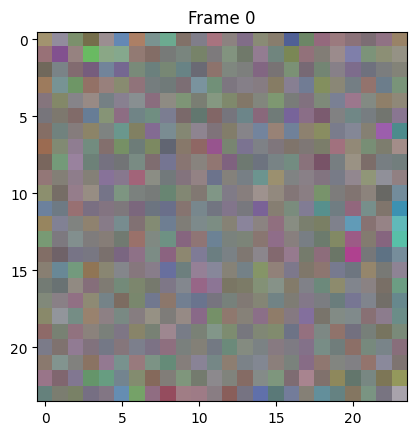

In [6]:
print(z.mean(), z.std())
frames = pred2frame(z)
print(frames.float().mean(), frames.float().std())
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

ani.save("sample_joint.gif", writer="pillow")

In [7]:
cache = model.create_cache(1)

In [8]:
from src.trainers.diffusion_forcing import sample

def render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=True, cache=cache):
    cache.reset()
    device = model.device
    frames = t.randn(1, actions.shape[1], 3, 24, 24, device="cpu")
    for aidx in range(actions.shape[1]):
        print(aidx)
        noise=t.randn(1, 1, 3, 24, 24, device=model.device)
        z = sample(model, noise, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions, cache=cache)
        frames[:, aidx:aidx+1] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [11]:
actions = t.tensor([[0] + 35*[3]], dtype=t.int32, device=model.device)
z = render_video(actions, n_steps=1, cfg=0, negative_actions=None, clamp=False)
frames = pred2frame(z)

0
extending cache knew norm: 112612.4453125, vnew norm: 72796.71875
k_new shape: torch.Size([8, 1, 65, 6, 66]), v_new shape: torch.Size([8, 1, 65, 6, 66])
k_new min: -1395.4422607421875, k_new max: 1481.135986328125
v_new min: -1582.9674072265625, v_new max: 2165.171142578125
k_new mean: 8.148978233337402, v_new mean: 2.181668758392334
k_new std: 248.03016662597656, v_new std: 160.4070281982422
k_new var: 61518.96484375, v_new var: 25730.416015625
1
extending cache knew norm: 125714.7109375, vnew norm: 80810.578125
k_new shape: torch.Size([8, 1, 65, 6, 66]), v_new shape: torch.Size([8, 1, 65, 6, 66])
k_new min: -1692.524658203125, k_new max: 1819.2481689453125
v_new min: -2409.23095703125, v_new max: 2029.5889892578125
k_new mean: 0.8965290188789368, v_new mean: 1.721484661102295
k_new std: 277.0357971191406, v_new std: 178.07371520996094
k_new var: 76748.8359375, v_new var: 31710.248046875
2
extending cache knew norm: 124780.140625, vnew norm: 80686.2109375
k_new shape: torch.Size([8,

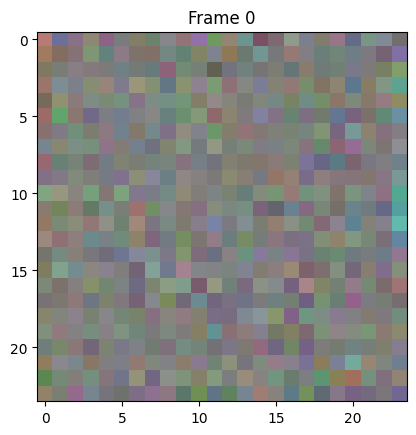

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")